2.0.0
episode:  0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 585       
Total params: 5,065
Trainable params: 5,065
Non-trainable params: 0
_________________________________________________________________


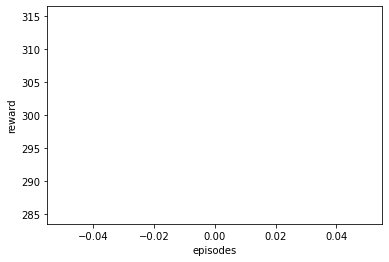

In [4]:
from sumobot import Sumobot
import tensorflow as tf
import random, sys
import numpy as np
from keras import Sequential
from collections import deque
import matplotlib.pyplot as plt
import os
# from tf.keras.layers import Dense
# from tf.keras.optimizers import Adam
print(tf.__version__)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

env = Sumobot()
np.random.seed(0)


class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space): #making the agent

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
        self.epsilon_decay = .995
        self.learning_rate = 0.001
        self.memory = deque(maxlen=100000)
        self.model = self.build_model()

    def build_model(self):
        
        model = tf.keras.Sequential() #groups a linear stack of layers into a model, provides training and inference features on this model
        model.add(tf.keras.layers.Dense(64, input_shape=(self.state_space,), activation='relu'))
        model.add(tf.keras.layers.Dense(64, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

#         print(np.random.rand() <= self.epsilon)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space) #choose a random move
        act_values = self.model.predict(state) # Generates output predictions for the input samples.
        return np.argmax(act_values[0]) 

    def replay(self):
    
#         print(len(self.memory))
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose = 0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            


def train_dqn(episode):

    loss = []
#     enemy_loss = []
    #sumobot and enemy action and state space
    action_space = 9
    state_space = 4
#     enemy_action_space = 1
    max_steps = 2000
    #sumobot agent
    agent = DQN(action_space, state_space)
    #enemy agent
#     enemy_agent = DQN(enemy_action_space, state_space)
    for e in range(episode):
        state = env.reset() # the only place where the algorithm resets the sumobot
        state = np.reshape(state, (1, state_space))
        #enemy state and reset in py
#         enemy_state = env.reset_enemy()
#         enemy_state = np.reshape(enemy_state, (1, state_space))
        score = 0
#         enemy_score = 0
        print("episode: ", e)
        for i in range(max_steps):
            #enemey agent
            action = agent.act(state)
#             enemy_action = enemy_agent.act(enemy_state)
            reward, next_state, done = env.step(action)
#             enemy_reward, enemy_next_state, enemy_done = env.step_enemy(enemy_action)
            score += reward
#             enemy_score += enemy_reward
            next_state = np.reshape(next_state, (1, state_space))
#             enemy_next_state = np.reshape(enemy_next_state, (1, state_space))
            agent.remember(state, action, reward, next_state, done)
#             enemy_agent.remember(enemy_state, enemy_action, enemy_reward, enemy_next_state, enemy_done)
            state = next_state
#             enemy_state = enemy_next_state
            agent.replay()
#             enemy_agent.replay()
            if done:
#                 print("episode: {}/{}, score: {}".format(e, episode, score))
                agent.model.summary()
#                 enemy_agent.model.summary()
                break
        loss.append(score)
#         enemy_loss.append(enemy_score)
    #save both models
    converter = tf.lite.TFLiteConverter.from_keras_model(agent.model)
    tflite_model = converter.convert()
#     tflite_model.save("myModelLite1.h5")
    tflite_model_name = "mymodel.tflite"
    open(tflite_model_name, "wb").write(tflite_model)
    return loss #, enemy_loss


if __name__ == '__main__':
# So when the interpreter runs a module, the __name__ variable will be set as  __main__ if the module that is being run is the main program.
# But if the code is importing the module from another module, then the __name__  variable will be set to that module’s name.
# https://www.freecodecamp.org/news/if-name-main-python-example/
    ep = 1
    loss = train_dqn(ep)
#     print(loss)
    plt.plot([i for i in range(ep)], loss)
    plt.xlabel('episodes')
    plt.ylabel('reward')
    plt.show()